In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from tqdm.auto import tqdm
from livelossplot import PlotLosses
from scipy.signal import spectrogram
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

import re
import soundfile as sf
from scipy.signal import stft

sns.set_theme()

In [ ]:
DATA_ROOT = "data/train_small"
snr_re = re.compile(r"mix_snr_(-?\d+)\.wav$")

In [48]:
def list_examples(root=DATA_ROOT, max_examples=200):
    ex = []
    for d in sorted(glob.glob(os.path.join(root, "*"))):
        if not os.path.isdir(d):
            continue
        mix_files = glob.glob(os.path.join(d, "mix_snr_*.wav"))
        if not mix_files:
            continue
        mix = mix_files[0]
        m = snr_re.search(os.path.basename(mix))
        snr = int(m.group(1)) if m else None
        voice = os.path.join(d, "voice.wav")
        noise = os.path.join(d, "noise.wav")
        if os.path.exists(voice) and os.path.exists(noise):
            ex.append(
                {
                    "id": os.path.basename(d),
                    "mix": mix,
                    "voice": voice,
                    "noise": noise,
                    "snr": snr,
                }
            )
        if len(ex) >= max_examples:
            break
    return ex


def load_audio(path):
    x, sr = sf.read(path)
    if x.ndim > 1:
        x = x.mean(axis=1)
    return x.astype(np.float32), sr


def list_triplets(root):
    triplets = []
    for d in sorted(glob.glob(os.path.join(root, "*"))):
        if not os.path.isdir(d):
            continue
        mix_files = sorted(glob.glob(os.path.join(d, "mix_snr_*.wav")))
        if not mix_files:
            continue
        mix = mix_files[0]
        voice = os.path.join(d, "voice.wav")
        noise = os.path.join(d, "noise.wav")
        if os.path.exists(voice) and os.path.exists(noise):
            m = snr_re.search(os.path.basename(mix))
            snr = int(m.group(1)) if m else None
            triplets.append((mix, voice, noise, snr))
    return triplets

In [49]:
examples = list_examples()
print(f"Found {len(examples)} examples")

Found 200 examples


In [51]:
durations = []
srs = []

for ex in examples[:50]:
    x, sr = load_audio(ex["mix"])
    srs.append(sr)
    durations.append(len(x) / sr)

print("Sampling rates:", set(srs))
print(
    f"Duration mean={np.mean(durations):.2f}s, min={np.min(durations):.2f}s, max={np.max(durations):.2f}s"
)


Sampling rates: {8000}
Duration mean=10.00s, min=10.00s, max=10.00s


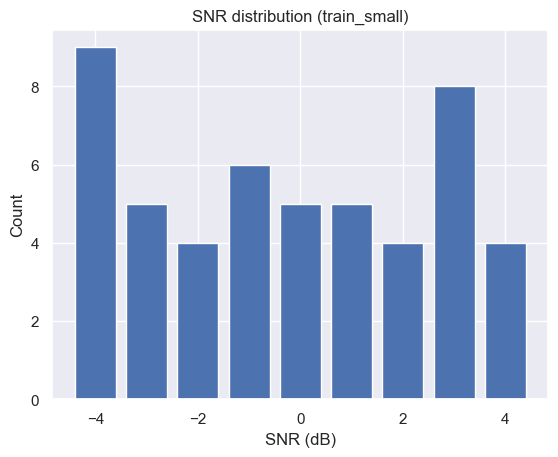

In [ ]:
snrs = np.array([ex["snr"] for ex in examples if ex["snr"] is not None])
u, c = np.unique(snrs, return_counts=True)

plt.bar(u, c)
plt.xlabel("SNR (dB)")
plt.ylabel("Count")
plt.title("SNR distribution (train_small)")
plt.show()


## SNR Distribution Analysis

The SNR values in the `train_small` subset span a wide range, from negative to positive values, indicating varying levels of difficulty in the source separation task.  
Low SNR examples (e.g. −4 dB) correspond to very noisy mixtures where the speech signal is weaker than the noise, while higher SNR values represent easier conditions.

The distribution is relatively balanced across SNR levels, which is beneficial for training and evaluation.  
It ensures that the models are exposed to both challenging and easier scenarios, allowing us to assess robustness to noise and performance consistency across different noise conditions.


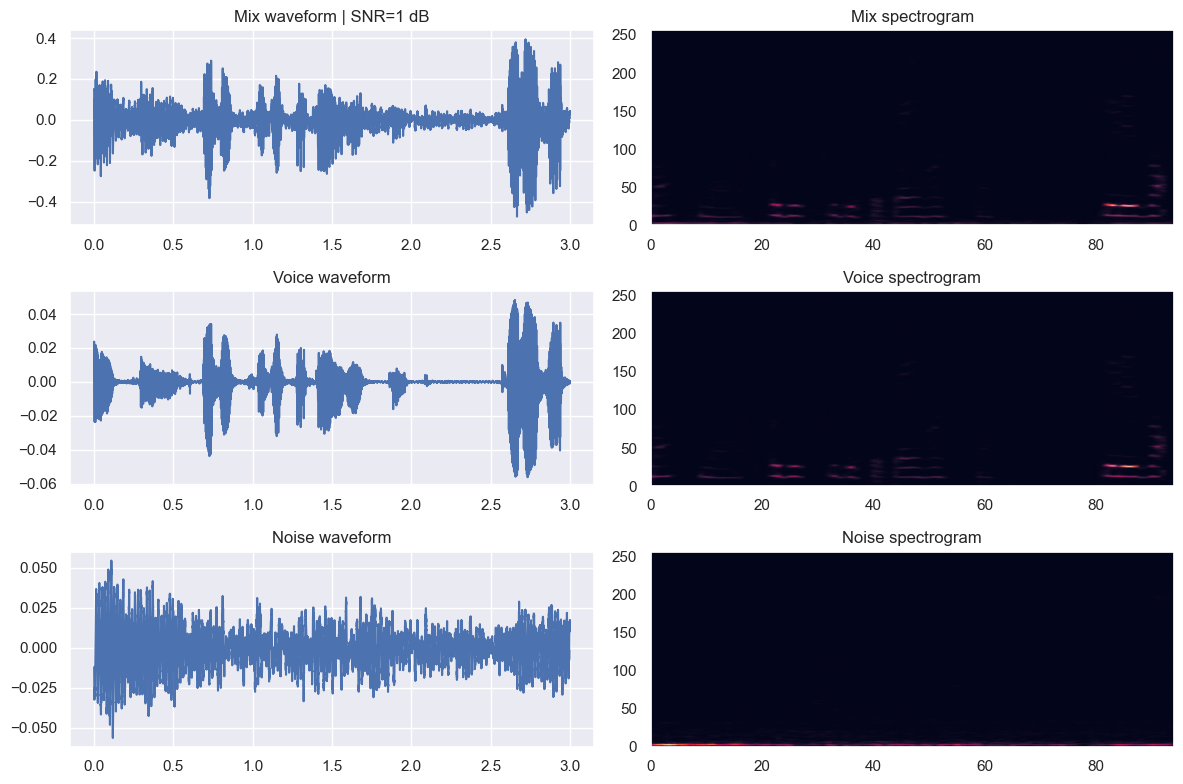

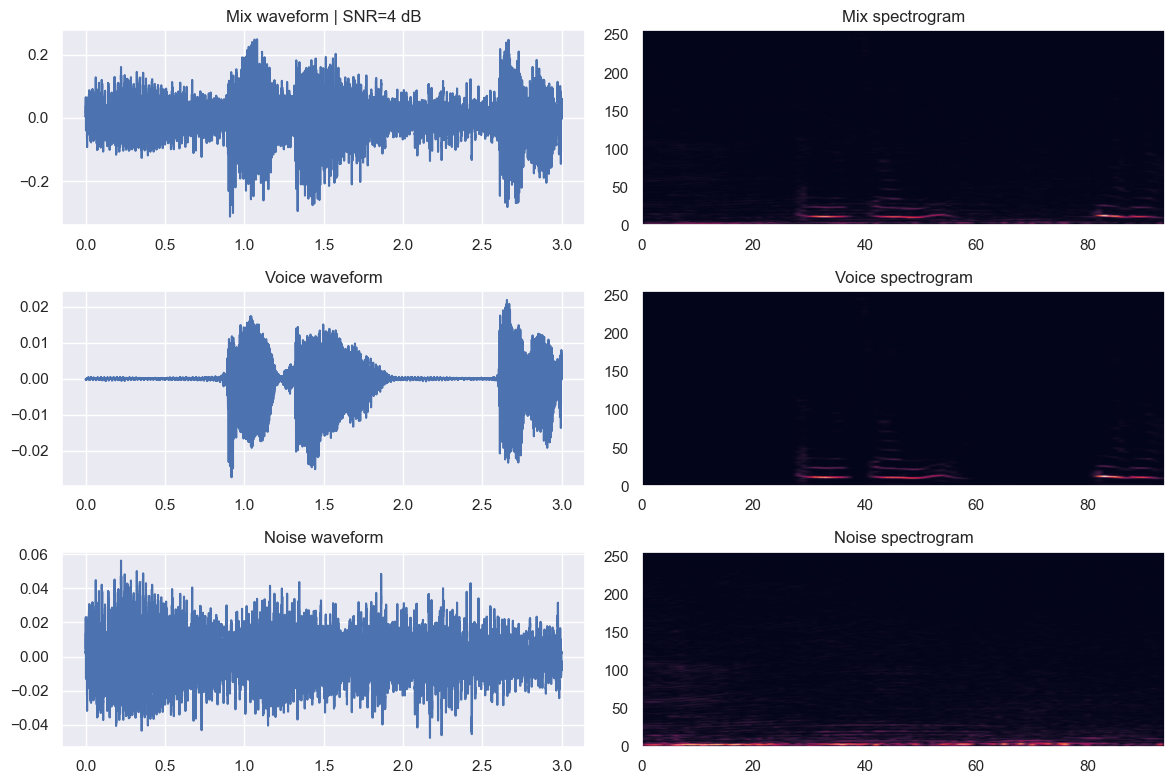

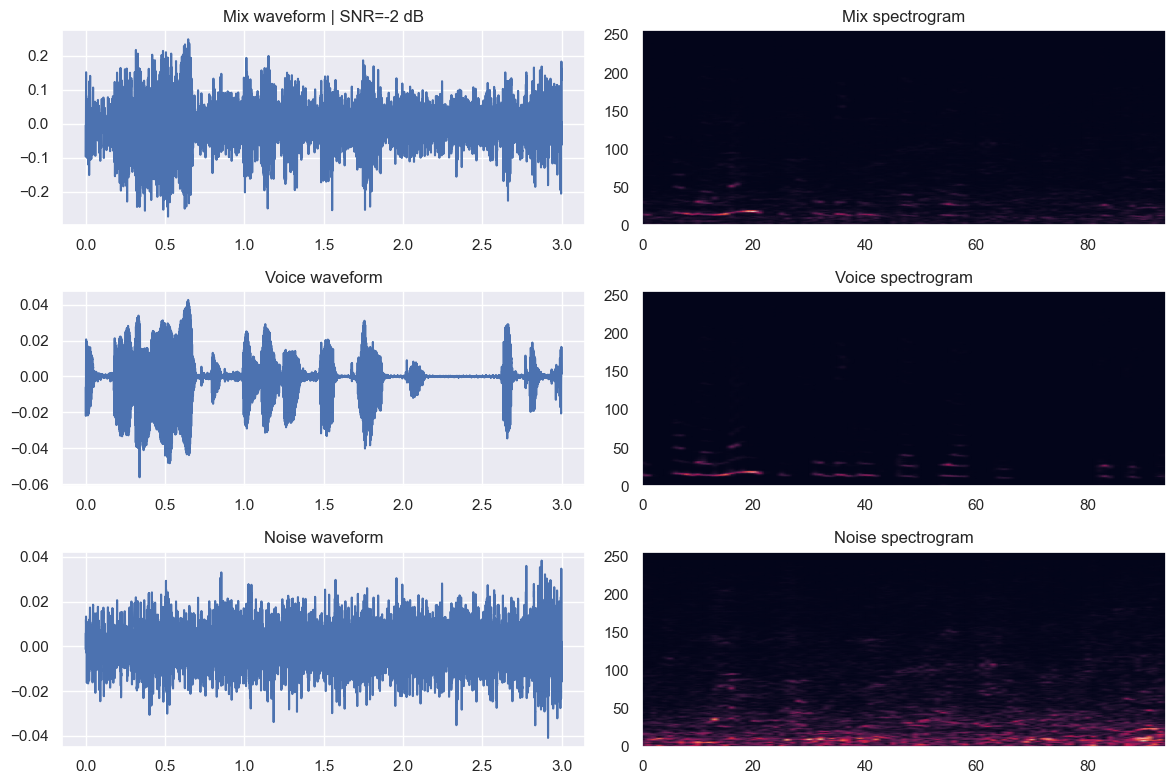

In [ ]:
def plot_example(ex, max_sec=3.0):
    mix, sr = load_audio(ex["mix"])
    voice, _ = load_audio(ex["voice"])
    noise, _ = load_audio(ex["noise"])

    T = int(max_sec * sr)
    mix, voice, noise = mix[:T], voice[:T], noise[:T]
    t = np.arange(len(mix)) / sr

    f, _, Smix = stft(mix, fs=sr, nperseg=512)
    _, _, Svoice = stft(voice, fs=sr, nperseg=512)
    _, _, Snoise = stft(noise, fs=sr, nperseg=512)

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 2, 1)
    plt.plot(t, mix)
    plt.title(f"Mix waveform | SNR={ex['snr']} dB")

    plt.subplot(3, 2, 3)
    plt.plot(t, voice)
    plt.title("Voice waveform")

    plt.subplot(3, 2, 5)
    plt.plot(t, noise)
    plt.title("Noise waveform")

    plt.subplot(3, 2, 2)
    plt.pcolormesh(np.abs(Smix), shading="gouraud")
    plt.title("Mix spectrogram")

    plt.subplot(3, 2, 4)
    plt.pcolormesh(np.abs(Svoice), shading="gouraud")
    plt.title("Voice spectrogram")

    plt.subplot(3, 2, 6)
    plt.pcolormesh(np.abs(Snoise), shading="gouraud")
    plt.title("Noise spectrogram")

    plt.tight_layout()
    plt.show()


rng = np.random.default_rng(0)
for ex in rng.choice(examples, size=min(3, len(examples)), replace=False):
    plot_example(ex)


In [ ]:
def si_sdr(est, ref, eps=1e-8):
    est = np.asarray(est, dtype=np.float64)
    ref = np.asarray(ref, dtype=np.float64)
    T = min(len(est), len(ref))
    est, ref = est[:T], ref[:T]
    est = est - est.mean()
    ref = ref - ref.mean()

    s_target = (np.dot(est, ref) / (np.dot(ref, ref) + eps)) * ref
    e_noise = est - s_target
    return 10.0 * np.log10(
        (np.dot(s_target, s_target) + eps) / (np.dot(e_noise, e_noise) + eps)
    )


In [ ]:
def load_audio(path):
    x, sr = sf.read(path)
    if x.ndim > 1:
        x = x.mean(axis=1)
    return x, sr


def oracle_mask_separation(mix, voice, noise, sr, nperseg=1024, noverlap=768, eps=1e-8):
    # STFT
    f, t, X = stft(mix, fs=sr, nperseg=nperseg, noverlap=noverlap)
    _, _, V = stft(voice, fs=sr, nperseg=nperseg, noverlap=noverlap)
    _, _, N = stft(noise, fs=sr, nperseg=nperseg, noverlap=noverlap)

    # Ratio masks on magnitude
    Vm = np.abs(V)
    Nm = np.abs(N)
    denom = Vm + Nm + eps
    Mv = Vm / denom
    Mn = Nm / denom

    Vhat = Mv * X
    Nhat = Mn * X

    # iSTFT
    _, vhat = istft(Vhat, fs=sr, nperseg=nperseg, noverlap=noverlap)
    _, nhat = istft(Nhat, fs=sr, nperseg=nperseg, noverlap=noverlap)
    return vhat, nhat


In [ ]:
def eval_oracle(examples, k=20):
    scores_v, scores_n = [], []
    for ex in examples[:k]:
        mix, sr = load_audio(ex["mix"])
        voice, _ = load_audio(ex["voice"])
        noise, _ = load_audio(ex["noise"])

        T = min(len(mix), len(voice), len(noise))
        mix, voice, noise = mix[:T], voice[:T], noise[:T]

        vhat, nhat = oracle_mask_separation(mix, voice, noise, sr)

        scores_v.append(si_sdr(vhat, voice))
        scores_n.append(si_sdr(nhat, noise))

    return float(np.mean(scores_v)), float(np.mean(scores_n))


mean_v, mean_n = eval_oracle(examples, k=20)
print(f"Oracle mask SI-SDR | Voice: {mean_v:.2f} dB | Noise: {mean_n:.2f} dB")


Oracle mask SI-SDR | Voice: 13.91 dB | Noise: 13.34 dB


## Analysis of the Oracle Mask Results

The oracle ratio mask achieves approximately **13.9 dB SI-SDR for the speech signal** and **13.3 dB SI-SDR for the noise signal**.

These results indicate that the dataset is consistent and that the STFT/iSTFT reconstruction pipeline is correct.  
They also show that the source separation task is non-trivial: even with perfect knowledge of the true speech and noise signals, the separation quality is limited.

This performance represents an **upper bound** for time–frequency masking approaches using the mixture phase.  
Consequently, any realistic method should obtain lower SI-SDR values, while a well-trained deep learning model is expected to approach this bound but not exceed it.


# Dataset

In [19]:
class SourceSepDataset(Dataset):
    def __init__(self, root, nperseg=1024, noverlap=768, max_seconds=2.0, eps=1e-8):
        self.items = list_triplets(root)
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.max_seconds = max_seconds
        self.eps = eps

    def __len__(self):
        return len(self.items)

    def _stft_mag(self, x, sr):
        # crop/pad to fixed length
        L = int(self.max_seconds * sr)
        if len(x) < L:
            x = np.pad(x, (0, L - len(x)))
        else:
            x = x[:L]
        _, _, X = stft(
            x, fs=sr, nperseg=self.nperseg, noverlap=self.noverlap, boundary=None
        )
        mag = np.abs(X).astype(np.float32)  # (F, T)
        return mag

    def __getitem__(self, idx):
        mix_p, voice_p, noise_p, snr = self.items[idx]
        mix, sr = load_audio(mix_p)
        voice, sr2 = load_audio(voice_p)
        noise, sr3 = load_audio(noise_p)
        assert sr == sr2 == sr3, "Sampling rates mismatch"

        mix_mag = self._stft_mag(mix, sr)
        v_mag = self._stft_mag(voice, sr)
        n_mag = self._stft_mag(noise, sr)

        # ratio mask target for voice
        denom = v_mag + n_mag + self.eps
        mask_v = v_mag / denom  # (F, T) in [0,1]

        # log transform for stability
        X = np.log1p(mix_mag)
        Y = mask_v

        X = torch.from_numpy(X)[None, ...]  # (1,F,T)
        Y = torch.from_numpy(Y)[None, ...]  # (1,F,T)
        return X, Y


In [ ]:
from torch.utils.data import random_split, DataLoader

full_dataset = SourceSepDataset("data/train")

n_total = len(full_dataset)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)


Train: 4500 | Val: 500


# Model U-Net

In [67]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, groups=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(num_groups=min(groups, out_ch), num_channels=out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(num_groups=min(groups, out_ch), num_channels=out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base * 2, base * 4)

        self.up2 = nn.ConvTranspose2d(base * 4, base * 2, 2, stride=2)
        self.dec2 = DoubleConv(base * 4, base * 2)
        self.up1 = nn.ConvTranspose2d(base * 2, base, 2, stride=2)
        self.dec1 = DoubleConv(base * 2, base)

        self.out = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x1 = self.enc1(x)  # (B,base,F,T)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))

        y2 = self.up2(x3)
        y2 = self.dec2(torch.cat([y2, x2], dim=1))

        y1 = self.up1(y2)
        if y1.shape[-2:] != x1.shape[-2:]:
            y1 = F.interpolate(y1, size=x1.shape[-2:], mode="nearest")
        y1 = self.dec1(torch.cat([y1, x1], dim=1))

        return torch.sigmoid(self.out(y1))  # mask in [0,1]


print("Total parameters:", sum(p.numel() for p in UNet().parameters()))

Total parameters: 467233


In [68]:
def evaluate_si_sdr(model, loader, device, max_batches=10):
    model.eval()
    scores = []

    with torch.no_grad():
        for i, (X, Y) in enumerate(loader):
            if i >= max_batches:
                break

            X = X.to(device)
            Y = Y.to(device)

            mask_pred = model(X)

            # magnitude du mix
            mix_mag = torch.expm1(X)  # inverse log1p
            voice_hat_mag = mask_pred * mix_mag
            voice_gt_mag = Y * mix_mag

            # flatten time-freq → waveform proxy
            vhat = voice_hat_mag.flatten(1).cpu().numpy()
            vgt = voice_gt_mag.flatten(1).cpu().numpy()

            for b in range(vhat.shape[0]):
                scores.append(si_sdr(vhat[b], vgt[b]))

    model.train()
    return float(np.mean(scores))


In [ ]:
def train_unet(model, train_loader, val_loader, epochs=10, lr=1e-3, device="cpu"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.L1Loss()

    liveloss = PlotLosses()
    dataloaders = {"train": train_loader, "validation": val_loader}

    for epoch in range(epochs):
        logs = {}

        for phase in ["train", "validation"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0

            pbar = tqdm(
                dataloaders[phase],
                desc=f"Epoch {epoch+1}/{epochs} [{phase.upper()}]",
                leave=False,
            )

            for X, Y in pbar:
                X, Y = X.to(device), Y.to(device)

                with torch.set_grad_enabled(phase == "train"):
                    pred = model(X)
                    loss = loss_fn(pred, Y)

                    if phase == "train":
                        opt.zero_grad()
                        loss.backward()
                        opt.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase])

            if phase == "train":
                logs["loss"] = epoch_loss
                logs["si_sdr"] = evaluate_si_sdr(model, train_loader, device, max_batches=5)
            else:
                logs["val_loss"] = epoch_loss
                logs["val_si_sdr"] = evaluate_si_sdr(model, val_loader, device, max_batches=10)

        liveloss.update(logs)
        liveloss.send()

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f} | "
            f"si_sdr={logs['si_sdr']:.2f}, val_si_sdr={logs['val_si_sdr']:.2f}"
        )

    return model


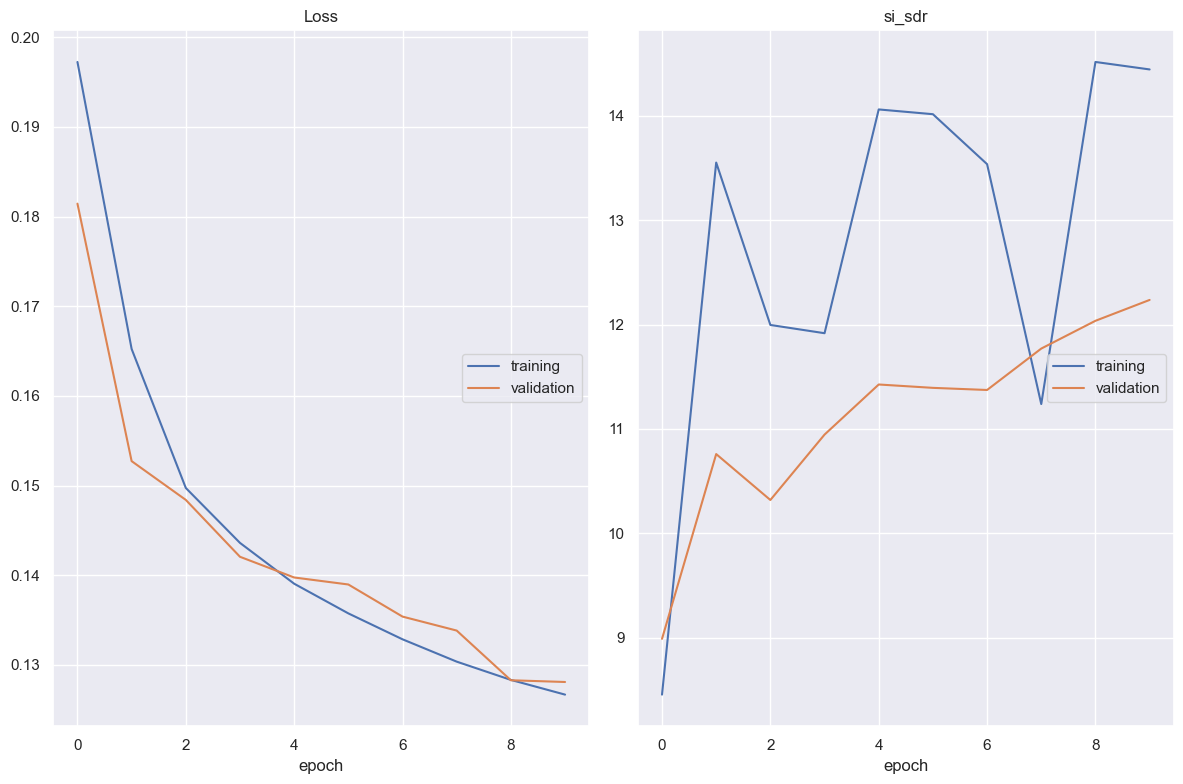

Loss
	training         	 (min:    0.127, max:    0.197, cur:    0.127)
	validation       	 (min:    0.128, max:    0.181, cur:    0.128)
si_sdr
	training         	 (min:    8.455, max:   14.516, cur:   14.444)
	validation       	 (min:    8.989, max:   12.236, cur:   12.236)
Epoch 10/10 | loss=0.1267, val_loss=0.1281 | si_sdr=14.44, val_si_sdr=12.24


In [70]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = UNet()

model = train_unet(model, train_loader, val_loader, epochs=10, device=device)